In [1]:
# This notebook looks into how existing vanilla transformers do math

In [4]:
# ----- dependencies
!pip install transformers 
#!pip install git+https://github.com/huggingface/transformers #accelerate deepspeed
!pip install -U huggingface_hub
!pip install -U accelerate
!pip install --upgrade pip
!pip install tokenizers==0.14.0
!pip install torch

  Using cached tokenizers-0.14.1-cp39-none-win_amd64.whl.metadata (6.8 kB)
  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
Using cached tokenizers-0.14.1-cp39-none-win_amd64.whl (2.2 MB)
Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.0
    Uninstalling tokenizers-0.13.0:
      Successfully uninstalled tokenizers-0.13.0
  Using cached huggingface_hub-0.18.0-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.18.0-py3-none-any.whl (301 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.18.0 which is incompatible.


  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
c:\Users\user2\Documents\GitHub\ICL-memorizing-transformer\.conda\python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
    --------------------------------------- 0.0/2.2 MB 330.3 kB/s eta 0:00:07
   - -------------------------------------- 0.1/2.2 MB 751.6 kB/s eta 0:00:03
   ------- -------------------------------- 0.4/2.2 MB 2.7 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/2.2 MB 4.5 MB/s eta 0:00:01
   ---------------------- ----------------- 1.2/2.2 MB 4.9 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 5.5 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 5.5 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 5.5 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 5.5 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 5.5 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 5.5 MB/s eta 0:00:01
   -------------------

In [6]:
# ----- dependencies
import os
import torch
from transformers import LlamaModel, LlamaConfig, LlamaForCausalLM
from huggingface_hub import login
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# --- character-level tokenizer
class Char_Tokenizer():

    def __init__(self):
        self.chars = ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9','+','=',' ']
        self.bos_token=1
        self.eos_token=2
        self.pad_token=0
        self.vocab_size = len(self.chars)
        self.char2idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx2char = {i: ch for i, ch in enumerate(self.chars)}

    def tokenize(self, text, max_length=None):
        list = [self.char2idx[ch] for ch in text]
        list.insert(0,self.bos_token) # prefix <s>
        list.append(self.eos_token) # suffix </s>
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [self.pad_token for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])
    
tokenizer = Char_Tokenizer()
vocab_size = tokenizer.vocab_size


In [8]:

# ----- HYPERPARAMETERS
LLM_context_length = 20 
LLM_hid =      384 # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to smalltansformers
LLM_layers =   6
LLM_n_heads =  6

# --- training
batch_size = 256
iterations = 5000
epochs = 1


In [11]:
# ------- Initialize model


# --- Create non-causal concept encoder (C) (tokens to concepts)
# the final autorecressive decoder-only model will use itself as the encoder - note that for char-level or removing tokenizer dependency we will need a separate encoder so that decoder take in only high level concepts
half_config = LlamaConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=LLM_hid,
    intermediate_size=LLM_hid*4,
    num_hidden_layers=LLM_layers,
    num_attention_heads=LLM_n_heads,
    num_key_value_heads=None,
    hidden_act='silu',
    max_position_embeddings=LLM_context_length,
    initializer_range=0.02,
    rms_norm_eps=1e-06,
    use_cache=True,
    pad_token_id=None,
    bos_token_id=tokenizer.bos_token,
    eos_token_id=tokenizer.eos_token,
    pretraining_tp=1,
    tie_word_embeddings=False,
    rope_theta=10000.0,
    rope_scaling=None)

# --- Create causal concept decoder (D) (concepts to concepts)
LLM_decoder = LlamaForCausalLM(half_config).to(device)#.to(torch.bfloat16)
LLM_decoder.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(16, 384)
    (layers): ModuleList(
      (0-5): 6 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=384, out_features=384, bias=False)
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=False)
          (o_proj): Linear(in_features=384, out_features=384, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=384, out_features=1536, bias=False)
          (up_proj): Linear(in_features=384, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=384, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_fea

In [12]:

# ------- TRAINING RUN
from transformers import top_k_top_p_filtering
import random


# --- Define the optimizer and loss function
optimizer = optim.AdamW(LLM_decoder.parameters(), lr=1e-4, betas=(0.9,0.99), weight_decay=0.1) # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to smalltansformers
warmup_iters = 100 # pre-ln transformers dont need warmup # # learning rate decay scheduler (cosine with warmup) from karpathy's nano-gpt
lr_decay_iters = iterations
learning_rate = 0.001
min_lr = 1e-5
import math
def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)



LLM_decoder.eval()

losses = []
accs = []
eval_losses = []
eval_accs = []
generations = []

LLM_decoder.train()
it = 0
for _ in range(epochs):
    for b in range(iterations):

        # get batch x, y
        batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
        for b_idx in range(batch_size):
            num1 = random.randint(0, 999)
            num2 = random.randint(0, 999)
            result = str(num1 + num2)
            problem = f"{num1}+{num2}={result}"
            tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
            batch_input_ids[b_idx][:] = torch.tensor(tokenized)

        labels = batch_input_ids.clone()
        labels[labels==tokenizer.pad_token] = -100

        # update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = get_lr(it)

        # forward pass
        output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
        loss = output.loss
    

        # Iterate through each sample in the batch
        b_accs=[]
        for s in range(batch_size):
            # Find the index of the token with value 14 in the 'labels' tensor for the current sample
            index_14 = (labels[s] == 14).nonzero(as_tuple=True)
            index_14 = index_14[0][0]
            # Calculate accuracy only for tokens after index_14 for the current sample
            predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
            correct_predictions = (predicted_labels[index_14+1:] == labels[s, index_14+1:].roll(-1, dims=0)).float()
            # Calculate the accuracy for tokens after index_14 for the current sample
            b_accs.append(correct_predictions.mean().item())
        accs.append(torch.tensor(b_accs).mean().item())

        # Step 5: Train D on the modified inputs and token labels
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(loss.item())

        it += 1

        # GET GENERATION SAMPLES (not optimized w/ cache):
        if it%100==0:
            with torch.no_grad():
                LLM_decoder.eval()



                # =============== EVAL LOSS
                batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
                for b_idx in range(batch_size):
                    num1 = random.randint(0, 999)
                    num2 = random.randint(0, 999)
                    result = str(num1 + num2)
                    problem = f"{num1}+{num2}={result}"
                    tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
                    batch_input_ids[b_idx][:] = torch.tensor(tokenized)
                labels = batch_input_ids.clone()

                # forward pass
                output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device)) # just start with first token
                loss = output.loss
                eval_losses.append(loss.item())

                # GET ACC
                b_accs=[]
                for s in range(batch_size):
                    # Find the index of the token with value 14 in the 'labels' tensor for the current sample
                    index_14 = (labels[s] == 14).nonzero(as_tuple=True)
                    index_14 = index_14[0][0]
                    eos = (labels[s] == tokenizer.eos_token).nonzero(as_tuple=True)
                    eos = eos[0][0]
                    # Calculate accuracy only for tokens after index_14 for the current sample
                    predicted_labels = torch.argmax(output.logits[s], dim=-1).cpu()
                    predicted_number = predicted_labels[index_14:eos-1]
                    correct_number = labels[s,index_14+1:eos]
                    predicted_number = tokenizer.detokenize(predicted_number.tolist())
                    correct_number = tokenizer.detokenize(correct_number.tolist()) 
                    #print('Y_:'+predicted_number)
                    #print('Y:'+correct_number)
                    #print()
                    
                    # whole number acc
                    if True:
                        try:
                            b_accs.append(float(int(predicted_number)==int(correct_number)))
                        except:
                            b_accs.append(0)
                    # per digit acc
                    else:
                        correct_predictions = (predicted_labels[index_14:eos-1] == labels[s, index_14+1:eos]).float()
                        b_accs.append(correct_predictions.mean().item())
                
                eval_accs.append(torch.tensor(b_accs).mean().item())


                # ============================================================================ GENERATIVE AUTOREGRESSIVE INFERENCE
                input_ids = torch.tensor([[tokenizer.bos_token]])
                while input_ids.shape[1] < LLM_context_length:
                    output = LLM_decoder(input_ids=input_ids.to(device))
                    logits = output.logits.cpu()
                    next_token_logits = logits[:, -1, :]
                    next_token_id = torch.multinomial(torch.softmax(next_token_logits, dim=-1), 1)
                    input_ids = torch.cat([input_ids, next_token_id], dim=1)
                print(tokenizer.detokenize(input_ids[0].tolist()))
                LLM_decoder.train()

                print(it,':', eval_losses[-1], eval_accs[-1], 'lr',get_lr(it))


<s>555+31=695</s></s></s></s></s></s></s></s></s>
100 : 3.8018605709075928 0.0 lr 0.001


KeyboardInterrupt: 

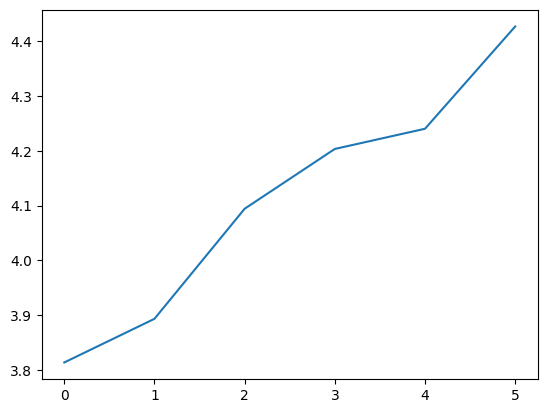

In [51]:
import matplotlib.pyplot as plt
plt.plot(eval_losses)

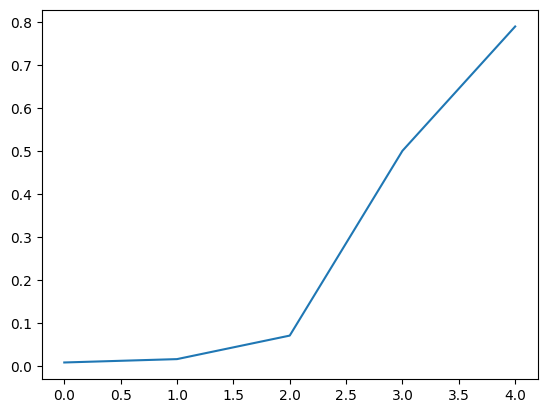

In [52]:
plt.plot(eval_accs)

In [ ]:
!pip install bertviz
from bertviz import model_view


# create math input
batch_size=1
batch_input_ids = torch.zeros([batch_size,LLM_context_length],dtype=torch.long)
num1 = random.randint(0, 999)
num2 = random.randint(0, 999)
result = str(num1 + num2)
problem = f"{num1}+{num2}={result}"
tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
batch_input_ids[b_idx][:] = torch.tensor(tokenized)

labels = batch_input_ids.clone()
labels[labels==tokenizer.pad_token] = -100

# forward pass
LLM_decoder.eval()
output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_attentions=True) 
attention = output[-1]

model_view(attention, batch_input_ids[0])
